Extracting input/fashion/train-images-idx3-ubyte.gz
Extracting input/fashion/train-labels-idx1-ubyte.gz
Extracting input/fashion/t10k-images-idx3-ubyte.gz
Extracting input/fashion/t10k-labels-idx1-ubyte.gz
9999                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

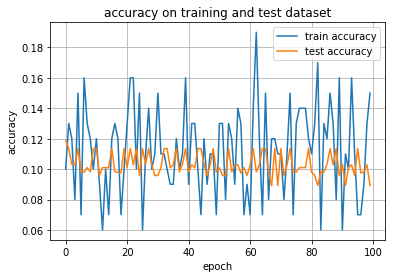

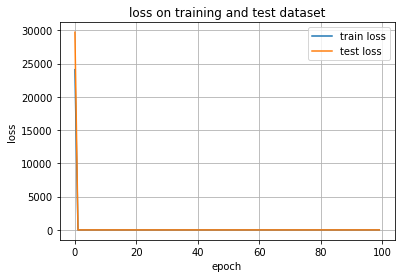

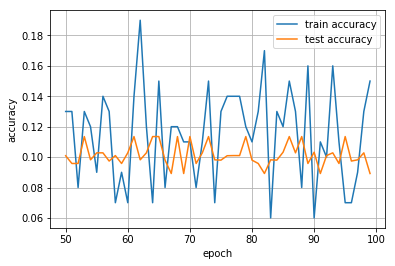

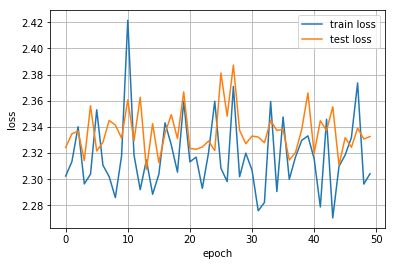

 Final test accuracy 0.0892
Final test loss 2.33261


In [9]:
# all tensorflow api is accessible through this
import tensorflow as tf        
# to visualize the resutls
import matplotlib.pyplot as plt 
# 70k mnist dataset that comes with the tensorflow container
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np


IMAGE_SIZE = 28
NUM_CHANNELS = 1

tf.set_random_seed(0)

# load data
mnist = input_data.read_data_sets('input/fashion', one_hot=True)

# 1. Define Variables and Placeholders
XX = tf.placeholder(tf.float32, [None, IMAGE_SIZE * IMAGE_SIZE])
x_image = tf.reshape(XX, [-1, 28, 28, 1])
# correct labels
Y_ = tf.placeholder(tf.float32, [None, 10])

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)


def conv2d(x, W, strides):
  return tf.nn.conv2d(x, W, strides, padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')


#learning rate placeholder
globalStep = tf.Variable(0, trainable=False)
lr = tf.train.exponential_decay(0.5, globalStep, 10000, 0.96, staircase = True)
# placeholder for probability of keeping a node during dropout = 1.0 at test time (no dropout) and 0.75 at training time
pkeep = tf.placeholder(tf.float32)

#XX = tf.reshape(X, [-1, 784])

# 2. Define the model
# create first conv layer
W1 = weight_variable([5, 5, 1, 4])
B1 = bias_variable([4])
strides1 = [1, 1, 1, 1]
Y1 = tf.nn.relu(conv2d(x_image, W1, strides1) + B1)

W2 = weight_variable([5, 5, 4, 8])
B2 = bias_variable([8])
strides2 = [1, 2, 2, 1]
Y2 = tf.nn.relu(conv2d(Y1, W2, strides2) + B2)

W3 = weight_variable([4, 4, 8, 12])
B3 = bias_variable([12])
strides3 = strides2
Y3 = tf.nn.relu(conv2d(Y2, W3, strides3) + B3)

pkeep = tf.placeholder(tf.float32, [])

Y3_reshaped = tf.reshape(Y3,[-1,7*7*12])

W4 = weight_variable([7*7*12,200])
B4 = bias_variable([200])
Y4 = tf.nn.relu(tf.matmul(Y3_reshaped, W4) + B4)

W5 = weight_variable([200,10])
B5 = bias_variable([10])
Ylogits = tf.matmul(Y4, W5) + B5

Y = tf.nn.softmax(Ylogits)

# 3. Define the loss function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels = Y_, logits = Ylogits) # calculate cross-entropy with logits
cross_entropy = tf.reduce_mean(cross_entropy)

# 4. Define the accuracy
is_correct = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

# 5. Define an optimizer
#optimizer = tf.train.GradientDescentOptimizer(0.5)
optimizer = tf.train.AdamOptimizer(lr)
#train_step = optimizer.minimize(cross_entropy)
train_step = optimizer.minimize(cross_entropy, global_step = globalStep)


# initialize
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)


def training_step(i, update_test_data, update_train_data):

    print "\r", i,
    ####### actual learning 
    # reading batches of 100 images with 100 labels
    batch_X, batch_Y = mnist.train.next_batch(100)
    # the backpropagation training step
    sess.run(train_step, feed_dict={XX: batch_X, Y_: batch_Y, pkeep: 0.75})
    
    ####### evaluating model performance for printing purposes
    # evaluation used to later visualize how well you did at a particular time in the training
    train_a = []
    train_c = []
    test_a = []
    test_c = []
    if update_train_data:
        a, c = sess.run([accuracy, cross_entropy], feed_dict={XX: batch_X, Y_: batch_Y, pkeep: 1})
        train_a.append(a)
        train_c.append(c)

    if update_test_data:
        a, c = sess.run([accuracy, cross_entropy], feed_dict={XX: mnist.test.images, Y_: mnist.test.labels, pkeep: 1})
        test_a.append(a)
        test_c.append(c)

    
    return (train_a, train_c, test_a, test_c)


# 6. Train and test the model, store the accuracy and loss per iteration

train_a = []
train_c = []
test_a = []
test_c = []
    
training_iter = 10000
epoch_size = 100
for i in range(training_iter):
    test = False
    if i % epoch_size == 0:
        test = True
    a, c, ta, tc = training_step(i, test, test)
    train_a += a
    train_c += c
    test_a += ta
    test_c += tc
    
# 7. Plot and visualise the accuracy and loss

# accuracy training vs testing dataset
plt.title("accuracy on training and test dataset")
plt.plot(train_a, label = "train accuracy")
plt.plot(test_a, label = "test accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# loss training vs testing dataset
plt.title("loss on training and test dataset")
plt.plot(train_c, label = "train loss")
plt.plot(test_c, label = "test loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# Zoom in on the tail of the plots
zoom_point = 50
x_range = range(zoom_point,training_iter/epoch_size)
plt.plot(x_range, train_a[zoom_point:], label = "train accuracy")
plt.plot(x_range, test_a[zoom_point:], label = "test accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()

plt.plot(train_c[zoom_point:], label = "train loss")
plt.plot(test_c[zoom_point:], label = "test loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(loc="best")
plt.grid(True)
plt.show()

print('Final test accuracy ' + str(test_a[-1]))
print('Final test loss ' + str(test_c[-1]))

GD optimizer with learning rate 0.5

   Final test accuracy 0.1032
   Final test loss 2.30223

Adam without dropout, without decay, rate 0.001

Final test accuracy 0.9849
Final test loss 0.0685546

Adam with learning rate decay

Final test accuracy 0.0892
Final test loss 2.33261

Adam with dropout and learning rate decay


- Define the output structure of the convolutional layers based on the given stride.

1x28x28

4x28x28

8x14x14

12x7x7

588

10

- For each of the programming subtasks 2-4 point out the changes that happen to the accuracy and error and explain why your modifications caused those changes.